# Gather protein structures and amino acid features
This notebook generates a dict with diverse protein features for each protein

TODO: remove context radius for simplicity

In [1]:
import pickle
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.PDB import *
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
from pyaaisc import Aaindex
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as matplotlib
import seaborn as sns 
import nglview as nv

from utils.plotting import *
from utils.processing import *

# set styles
plt.style.use('./utils/domain_ins.mplstyle')
plt.rcParams['svg.fonttype'] = 'none'

/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(


### Define parameters

In [3]:
base = '/work/projects/project01640/jm/domain_insertion/DI_screen'
in_folder = f'{base}/analysis/input_data'
data_folder = f'{base}/analysis/output_datasets'
fig_folder = f'{base}/analysis/figures'
primary_proteins = {rec.id : rec.seq for rec in SeqIO.parse(f'{in_folder}/proteins.fasta', 'fasta')}

#sequencing data:
# import analysis dict
with open(f'{data_folder}/analysis_dict.pickle', 'rb') as input:
    analysis_dict = pickle.load(input)
input.close()

# background AA frequences Swissprot release 2022_04
background_AA ={'A':0.0825, 'Q':0.0393, 'L':0.0965, 'S':0.0664, 'R':0.0553, 'E':0.0672, 'K':0.0580, 'T':0.0535, 'N':0.0406, 'G':0.0707,
                'M':0.0241, 'W':0.0110, 'D':0.0546, 'H':0.0227, 'F':0.0386, 'Y':0.0292, 'C':0.0138, 'I':0.0591, 'P':0.0474, 'V':0.0686}

#define features that should be taken into account 
feature_dict_radius = {'Hydrophobicity':'PRAM900101', 'Flexibility_idx':'BHAR880101', 'Molecular_weight':'FASG760101', 'Average_volume':'PONJ960101', 
'Positive_charge':'FAUJ880111', 'Negative_charge':'FAUJ880112', 'Net_charge':'KLEP840101', 'Radius_of_gyration':'LEVM760105',
 'Side-chain_stab_idx':'TAKK010101', 'Stability_scale_atom':'ZHOH040101', 'Stability_scale_experiment':'ZHOH040102', 'Buriability':'ZHOH040103'}
feature_dict_sequential = {'Linker_idx_Suyama':'SUYM030101', 'Linker_idx_George':'GEOR030101', 'Linker_idx_Bae':'BAEK050101'}

### Fetch features from AAindex DB, MSAs adn PDB files

In [4]:
feat_dict_radius = import_features(feature_dict_radius)
feat_dict_sequential = import_features(feature_dict_sequential)

In [5]:
#process alignments and store data in dict
data_dict = {}
uniprot = {'AraC', 'TVMV', 'Flp', 'SigF'}
for protein in uniprot:
        data_dict[f'{protein}_data']={}
        data_dict[f'{protein}_data']['alignment_df'], data_dict[f'{protein}_data'][f'{protein}_positions'],  data_dict[f'{protein}_data']['alignment_counts'] = process_alignment(f'{protein}_ref_aln.afa', protein)
        data_dict[f'{protein}_data']['KLD'], data_dict[f'{protein}_data']['query_idx'] = KLD(data_dict[f'{protein}_data']['alignment_counts'], background_AA, data_dict[f'{protein}_data'][f'{protein}_positions'])
        data_dict[f'{protein}_data'] = insertion_stats(data_dict[f'{protein}_data']['query_idx'], primary_proteins[protein], data_dict[f'{protein}_data'])
        del data_dict[f'{protein}_data']['alignment_df'], data_dict[f'{protein}_data'][f'{protein}_positions'], data_dict[f'{protein}_data']['alignment_counts'], data_dict[f'{protein}_data']['query_idx']
        data_dict[f'{protein}_data'] = pd.DataFrame.from_dict(data_dict[f'{protein}_data'])

In [10]:
#construct dataset
thresholds = {}
input_pdbs = ['AraC', 'Flp', 'SigF','TVMV']

for protein in input_pdbs:  
    thresholds[f'{protein}_thresholds'] = {}
    thresholds[f'{protein}_thresholds']['2'] = collect_training_data(2, data_dict[f'{protein}_data'], protein, feat_dict_radius, feat_dict_sequential, primary_proteins, analysis_dict, in_folder)

/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/Bio/PDB/PDBParser.py:395: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 2363
  warnings.warn(


NameError: name 'find_proximal_AAs' is not defined

In [6]:
#dump the current dataset to pickle
with open(f'{in_folder}/proteins_training.pickle', 'wb') as f:
    pickle.dump(thresholds, f) 
f.close() 

In [ ]:
#import property dict
with open(f'{in_folder}/proteins_training.pickle', 'rb') as input:
    thresholds = pickle.load(input)
input.close()

In [7]:
from scipy import stats
pd.set_option('display.max_rows', 1000)
def r(x, y):
    return stats.spearmanr(x, y)[0]

def correlation_plot(data, combination, property):
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(data=data, x=property, y='enrichment', color='grey', ci=None, 
        scatter_kws={'alpha':.5, 'linewidth':0}, line_kws={"linewidth":0, 
        'label':f"Spearman's r: {round(r(data[property], data['enrichment']), 2)}"})
    
    plt.xlabel(property)
    plt.ylabel("Log2 variant enrichment")
    sns.despine()
    g.tick_params(width=2)
    g.legend(frameon=False, loc='upper right')
    plt.title(f"{combination}", y=1.03)
    plt.savefig(f"{fig_folder}/correlation_{combination}_{property}.svg")

def violin_plot(data, combination, property):
    data = data.loc[data[property].notna()]
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    ax = sns.violinplot(data=data, x=property, y='enrichment', linewidth=2, color='grey', fliersize=0)
    #ax = sns.swarmplot(data=data, x=property, y='enrichment', alpha=.5, linewidth=0, color='black')
    plt.setp(ax.lines, color="0")
    plt.xlabel(property.replace('_', ' '))
    plt.ylabel("Log2 variant enrichment")
    sns.despine()
    plt.title(f"{combination}")
    ax.yaxis.set_tick_params(width=2)
    ax.xaxis.set_tick_params(width=2)
    ax.set_xticklabels(['Coil', '\u03B2-sheet', '\u03B1-helix'])
    plt.savefig(f"{fig_folder}/correlation_{combination}_{property}.svg")

/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 946 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/matplotlib/textpath.py:74: RuntimeWarning: Glyph 945 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/matplotlib/backends/backend_svg.py:1125: RuntimeWarning: Glyph 946 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/matplotlib/backends/backend_svg.py:1125: RuntimeWarning: Glyph 945 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/home/jm38sywy/miniconda3/envs/transformer/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 946 missing from current font.
  font.set_text(

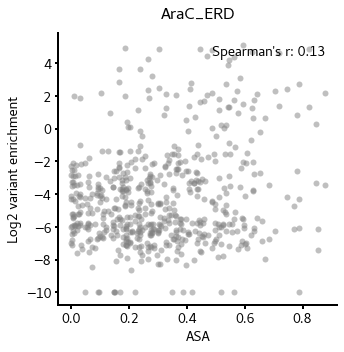

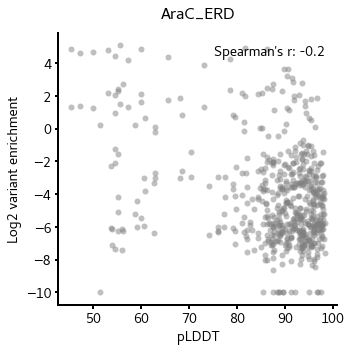

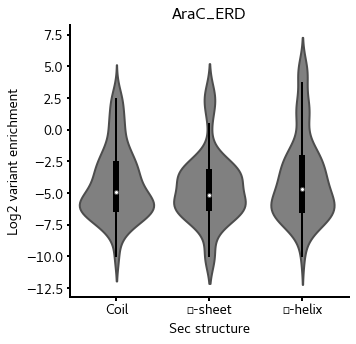

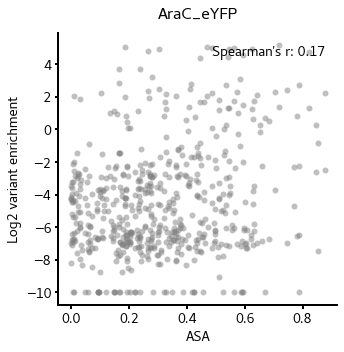

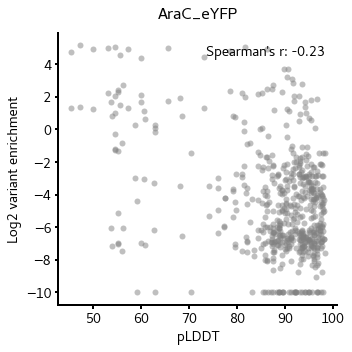

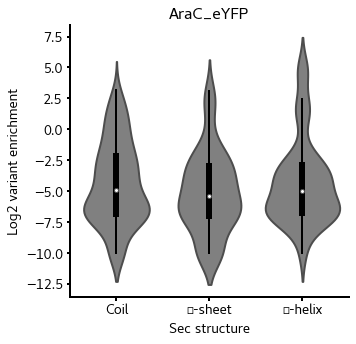

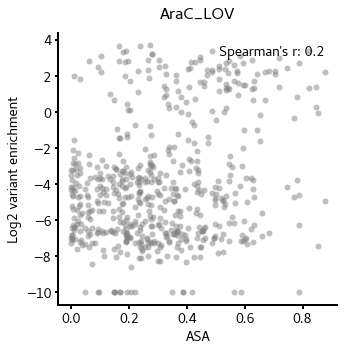

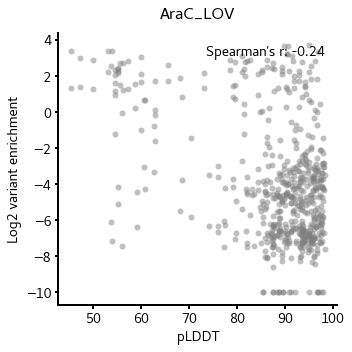

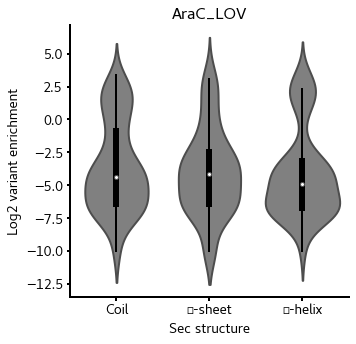

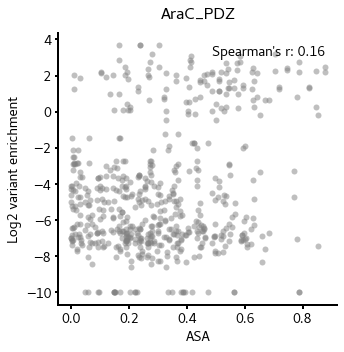

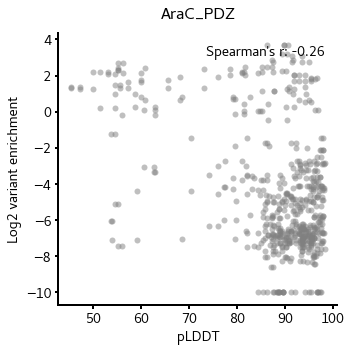

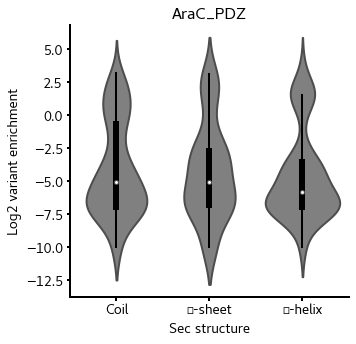

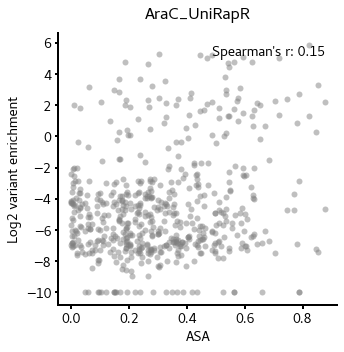

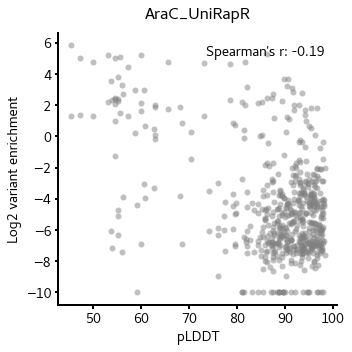

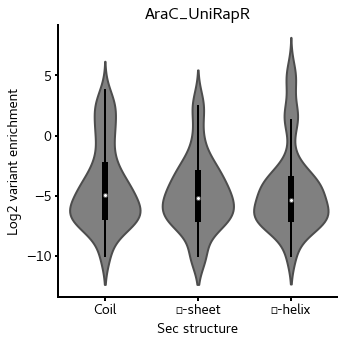

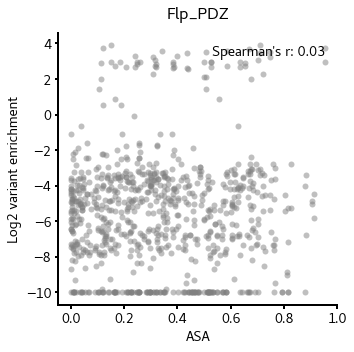

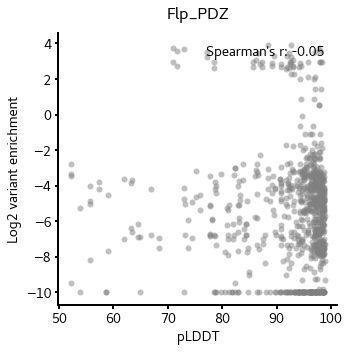

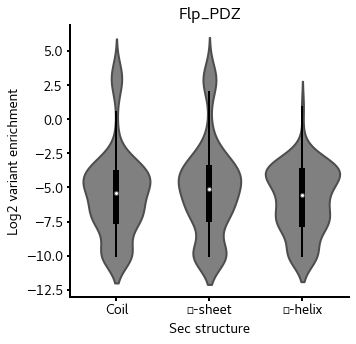

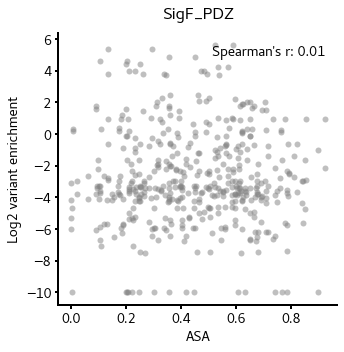

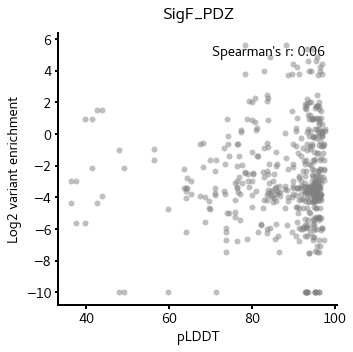

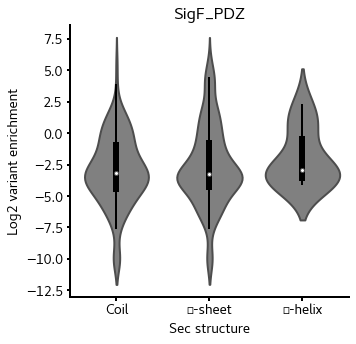

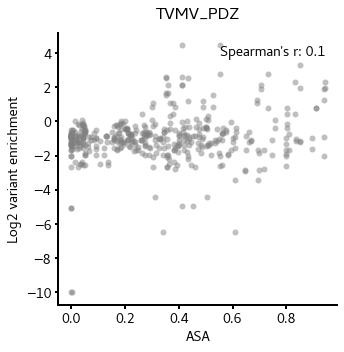

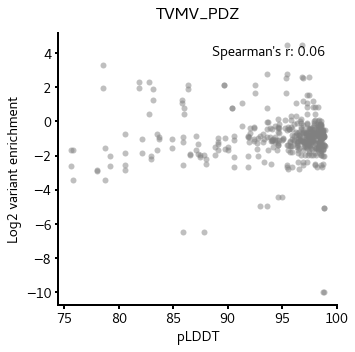

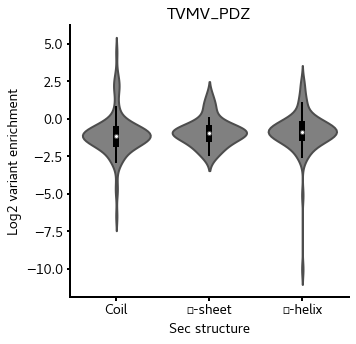

In [8]:
with open(f'{in_folder}/proteins_training.pickle', 'rb') as input:
    thresholds = pickle.load(input)
input.close()

for name, radius_dict in thresholds.items():
    for name, df in radius_dict.items():
        df.dropna(inplace=True)
#print output dataframes
#TODO include the features after induction
property_dict = {}
for i in analysis_dict.items():
        #select samples from second enrichment and average them, if 2 replicates are available
        temp_dict = {}
        for idx, frame in i[1].items():
            if len(idx) == 2 and idx[1] == '2':
                temp_dict[idx] = frame
        if len(temp_dict) == 1: 
            out_df = list(temp_dict.values())[0]['log']
        elif len(temp_dict) == 2:
            out_df = (temp_dict['12']['log'] + temp_dict['22']['log'])/2
        else:
            continue
        out_df = out_df.to_frame()
        complete_df = pd.concat([out_df.reset_index(), thresholds[f'{i[0].split("_")[0]}_thresholds']['2'].reset_index()], axis=1)
        complete_df.dropna(inplace=True)
        plot_df = complete_df[['log', 'Sec_structure', 'ASA', 'pLDDT']]   
        plot_df = plot_df.iloc[1:-1,:]
        plot_df = pd.melt(plot_df, id_vars=['Sec_structure', 'ASA', 'pLDDT'], value_vars=out_df.columns, value_name='enrichment')
        plot_df['ASA'] =plot_df['ASA'].astype('float')
        plot_df['pLDDT'] =plot_df['pLDDT'].astype('float')
        property_dict[i[0]] = complete_df
        correlation_plot(plot_df, i[0], 'ASA')
        correlation_plot(plot_df, i[0], 'pLDDT')
        violin_plot(plot_df, i[0], 'Sec_structure')
